In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms, datasets
import timm
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/images"

# Step 4: Define transformations
# Since DeiT expects 224x224 images, we resize them accordingly
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std dev for RGB
])

# Step 5: Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
model = timm.create_model('deit_small_patch16_224', pretrained=True)

# Modify the input layer for grayscale (1 channel to 3 channels conversion already done in transform)
# Modify the classifier head to output 4 classes
num_classes = 4
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)  # Replace classifier for 4 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Training function
# Training function with adaptive output reshaping
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Check if output shape is 4D (batch, num_classes, height, width) and adapt it
        if outputs.dim() == 4:
            outputs = outputs.mean([2, 3])  # Global average pooling to flatten spatial dimensions

        # Ensure output is now [batch_size, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc, precision, recall, f1



# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Adaptive output reshaping if necessary
            if outputs.dim() == 4:
                outputs = outputs.mean([2, 3])  # Flatten spatial dimensions

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc,precision, recall, f1
# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc,train_precision, train_recall, train_f1  = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_precision, val_recall, val_f1  = validate(model, val_loader, criterion)

    scheduler.step()  # Update the learning rate

    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")
    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

Epoch 1/10


100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


Training Loss: 0.1416, Accuracy: 94.62%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95
Validation Loss: 0.0248, Accuracy: 99.20%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch 2/10


100%|██████████| 78/78 [00:31<00:00,  2.50it/s]


Training Loss: 0.0063, Accuracy: 99.85%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0099, Accuracy: 99.60%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 3/10


100%|██████████| 78/78 [00:28<00:00,  2.72it/s]


Training Loss: 0.0152, Accuracy: 99.51%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0115, Accuracy: 99.72%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 4/10


100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


Training Loss: 0.0082, Accuracy: 99.79%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0038, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 5/10


100%|██████████| 78/78 [00:29<00:00,  2.65it/s]


Training Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 6/10


100%|██████████| 78/78 [00:29<00:00,  2.66it/s]


Training Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 7/10


100%|██████████| 78/78 [00:29<00:00,  2.68it/s]


Training Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 8/10


100%|██████████| 78/78 [00:29<00:00,  2.64it/s]


Training Loss: 0.0001, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 9/10


100%|██████████| 78/78 [00:29<00:00,  2.66it/s]


Training Loss: 0.0000, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 10/10


100%|██████████| 78/78 [00:28<00:00,  2.70it/s]

Training Loss: 0.0000, Accuracy: 100.00%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00
Validation Loss: 0.0034, Accuracy: 99.96%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00



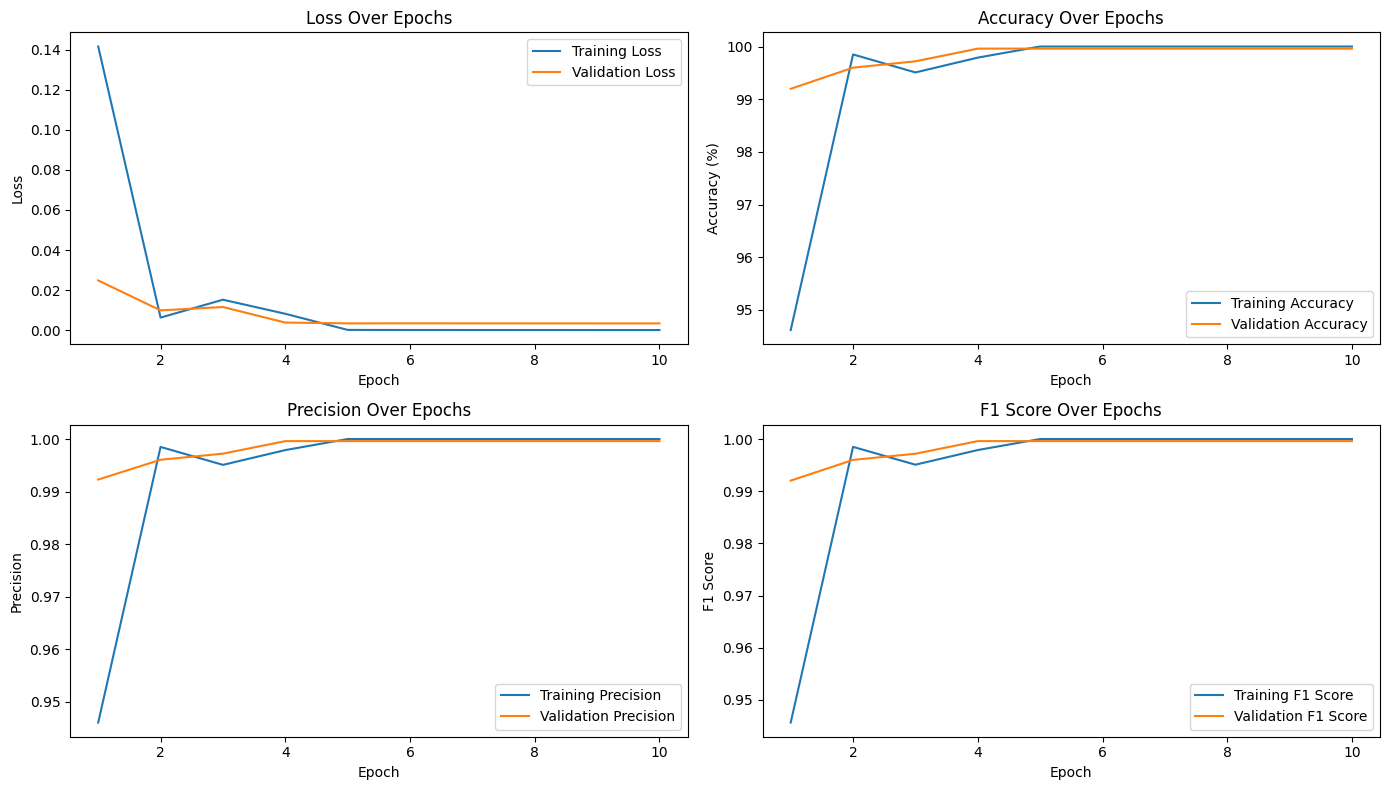

In [ ]:
epochs = np.arange(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()